In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
from nilearn.image import math_img
from t3f import initializers

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
ground_truth = np.array(x_true_org.get_data()).astype('float32')
ten_ones = np.ones_like(ground_truth).astype('float32')
ten_zeros = np.zeros_like(ground_truth).astype('float32')

Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [3]:
def init_random(x):
    init = (2*np.random.random_sample(x.shape) - 1).astype('float32')
    return init

In [4]:
def cost_with_treshold(x, thresh = 0.03):
    res = tf.abs(x)
    zeros = tf.zeros_like(x)
    masked = tf.greater(res, thresh)
    new_tensor = tf.where(masked, x, zeros)
    return new_tensor

In [5]:
#Initialize variables

In [6]:
x_init = copy.deepcopy(ground_truth)
norm_ground_x_init = np.linalg.norm(x_init)
x_init = x_init * (1./norm_ground_x_init)
tf_ten_zeros = t3f.to_tt_tensor(ten_zeros, max_tt_rank=63)
tf_ten_ones = t3f.to_tt_tensor(ten_ones, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [7]:
ground_truth_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)
#tf_zeros = t3f.get_variable('tf_zeros', initializer=tf_ten_zeros, trainable=False)
#tf_ones = t3f.get_variable('tf_ones', initializer=tf_ten_ones, trainable=False)
X = t3f.get_variable('X', initializer=ground_truth_tf, trainable=False)
L = t3f.get_variable('L', initializer=ground_truth_tf)
s_init = init_random(x_init)
s_init.fill(0)
s_init_tf = t3f.to_tt_tensor(s_init, max_tt_rank=63)
S = t3f.get_variable('S',initializer=s_init_tf)

#Sold = t3f.get_variable('Sold', initializer=tf_ten_zeros)
#G = t3f.get_variable('G', initializer=tf_ten_zeros)


[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [8]:
print S
#Initialize Gradienst

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [9]:
gradLt3f = X - S
gradSt3f = X - L

In [10]:
rimGradS = t3f.riemannian.project(gradSt3f,S)
rimGradL = t3f.riemannian.project(gradLt3f,L)

In [11]:
alpha = 0.01

train_step_tensor_s = t3f.assign(S, t3f.round(S + alpha * rimGradS, max_tt_rank=63))
train_step_tensor_l = t3f.assign(L, t3f.round(L + alpha * rimGradL, max_tt_rank=63))
normGradS = t3f.frobenius_norm(rimGradS)
normGradL = t3f.frobenius_norm(rimGradL)



Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [12]:
loss = 0.5 * t3f.frobenius_norm_squared(L + S - X)
normL_S = t3f.frobenius_norm(L + S - X)

In [13]:
def solution_stopping_criterion(ll,ss,xx):
    return (np.linalg.norm(ll + ss - xx)**2)/(np.linalg.norm(xx)**2)

In [14]:
def relative_convergence_error(solution, k):
    return np.linalg.norm(solution[k] - solution[k-1])/np.linalg.norm(solution[k-1])

In [15]:
solution_S = []
solution_L = []
solution_L_S = []

cost_S = []
cost_L = []

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
for i in range (10):
    S_val, norm_gradS_val,loss_val, L_val, norm_gradL_val, normL_S_val,_,_ = sess.run([t3f.full(S), normGradS, loss, t3f.full(L), normGradL, normL_S, train_step_tensor_s.op, train_step_tensor_l.op])
    #loss_val, L_val, norm_gradL_val, normL_S_val,_ = sess.run([loss, t3f.full(L), normGradL, normL_S, train_step_tensor_l.op])
    print "Iteration#: " + str(i) + "; loss: " + str(loss_val) + "; norm_gradL: " + str(norm_gradL_val) + "; norm_gradS: " + str(norm_gradS_val)
    print "Residual Norm: " + str(normL_S_val)
    solution_S.append(S_val)
    solution_L.append(L_val)
    solution_L_S.append(normL_S_val)
    
    solution_tolerance = solution_stopping_criterion(L_val, S_val, ground_truth)
    
    if i >= 1:
        cost_s_sol = relative_convergence_error(solution_S, i)
        cost_l_sol = relative_convergence_error(solution_L, i)
        cost_ls_sol = relative_convergence_error(solution_L_S, i)
        print "S Relative Error: " + str(cost_s_sol) + "; L Relative Error: " + str(cost_l_sol)
        print "Total Solution Relative Error: " + str(cost_ls_sol)
        
    print "Solution Tolerance: " + str(solution_tolerance)
        
    

loss: 2.7200735e-11; norm_gradL: 1.0001802; norm_gradS: 0.0031622776
Residual Norm: 0.0031622862
Solution Tolerance: 0.9999773615700057
loss: 4.9448794e-05; norm_gradL: 1.0002234; norm_gradS: 0.007653216
Residual Norm: 0.0104354005


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  


S Relative Error: inf; L Relative Error: 0.010000326
Total Solution Relative Error: 2.2999544
Solution Tolerance: 0.9999773615700057
loss: 0.0001949825; norm_gradL: 1.0004236; norm_gradS: 0.020252444
Residual Norm: 0.019999124
S Relative Error: 360616.8; L Relative Error: 0.009902432
Total Solution Relative Error: 0.9164692
Solution Tolerance: 0.9999773615700057
loss: 0.00043371372; norm_gradL: 1.0007232; norm_gradS: 0.030174952
Residual Norm: 0.029621402
S Relative Error: 2.8704028; L Relative Error: 0.009806969
Total Solution Relative Error: 0.48113495
Solution Tolerance: 0.9999773615700057
loss: 0.0007628705; norm_gradL: 1.0011228; norm_gradS: 0.04014111
Residual Norm: 0.03918853
S Relative Error: 1.1834428; L Relative Error: 0.0097147515
Total Solution Relative Error: 0.32298028
Solution Tolerance: 0.9999773615700057
loss: 0.0011794352; norm_gradL: 1.0016232; norm_gradS: 0.050128065
Residual Norm: 0.048671044
S Relative Error: 0.7263008; L Relative Error: 0.009625344
Total Solution

loss: 0.047263045; norm_gradL: 1.0712601; norm_gradS: 0.37855873
Residual Norm: 0.30746722
S Relative Error: 0.057825033; L Relative Error: 0.007802842
Total Solution Relative Error: 0.022911504
Solution Tolerance: 0.9999773615700057
loss: 0.049383197; norm_gradL: 1.0751519; norm_gradS: 0.38927135
Residual Norm: 0.31428713
S Relative Error: 0.056251783; L Relative Error: 0.007770228
Total Solution Relative Error: 0.022180913
Solution Tolerance: 0.9999773615700057
loss: 0.05152815; norm_gradL: 1.0791525; norm_gradS: 0.4000231
Residual Norm: 0.3210394
S Relative Error: 0.05476344; L Relative Error: 0.007738236
Total Solution Relative Error: 0.021484438
Solution Tolerance: 0.9999773615700057
loss: 0.053696085; norm_gradL: 1.0832598; norm_gradS: 0.41081458
Residual Norm: 0.3277227
S Relative Error: 0.053349685; L Relative Error: 0.0077074417
Total Solution Relative Error: 0.020817662
Solution Tolerance: 0.9999773615700057
loss: 0.055885036; norm_gradL: 1.0874776; norm_gradS: 0.4216477
Resi

S Relative Error: 0.0297873; L Relative Error: 0.007151392
Total Solution Relative Error: 0.009568307
Solution Tolerance: 0.9999773615700057
loss: 0.1322043; norm_gradL: 1.2826406; norm_gradS: 0.7966913
Residual Norm: 0.5142165
S Relative Error: 0.029400218; L Relative Error: 0.0071445615
Total Solution Relative Error: 0.009389519
Solution Tolerance: 0.9999773615700057
loss: 0.13464898; norm_gradL: 1.2907361; norm_gradS: 0.8095177
Residual Norm: 0.5189489
S Relative Error: 0.029024627; L Relative Error: 0.007138185
Total Solution Relative Error: 0.009203186
Solution Tolerance: 0.9999773615700057
loss: 0.13708898; norm_gradL: 1.2989612; norm_gradS: 0.82242465
Residual Norm: 0.5236296
S Relative Error: 0.028658833; L Relative Error: 0.007131946
Total Solution Relative Error: 0.009019565
Solution Tolerance: 0.9999773615700057
loss: 0.13952667; norm_gradL: 1.3073149; norm_gradS: 0.8354139
Residual Norm: 0.52826446
S Relative Error: 0.028304692; L Relative Error: 0.0071269753
Total Solution

In [18]:
#

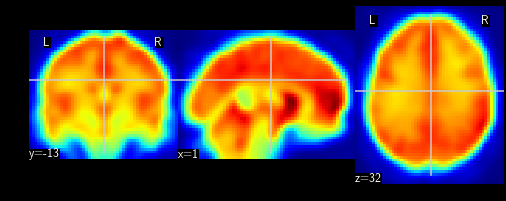

In [28]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_init)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

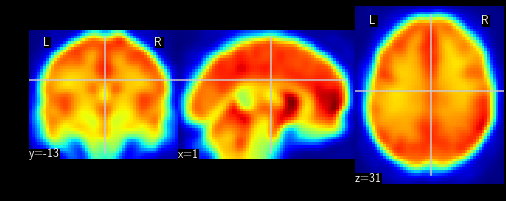

In [26]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, L_val)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

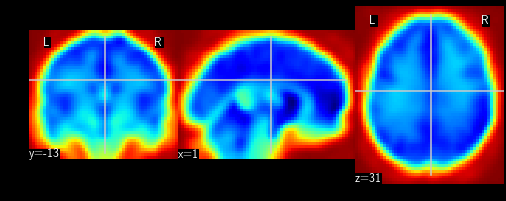

In [27]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, S_val)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [23]:
solution_tolerance = solution_stopping_criterion(L_val, S_val, x_init)

In [24]:
solution_tolerance

0.4022648338595282

In [29]:
import numpy.testing as nps

In [ ]:
G = xinit - L_val - S_val

In [ ]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, G)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [30]:
total = S_val + L_val + G

In [33]:
nps.assert_allclose(total, x_init, rtol=1e-4, atol=0)

AssertionError: 
Not equal to tolerance rtol=0.0001, atol=0

(mismatch 99.9999954787%)
 x: array([[[[1.095457e-05, 1.111091e-05, 1.083910e-05, ..., 1.118155e-05,
          1.107623e-05, 1.130198e-05],
         [1.205299e-05, 1.227847e-05, 1.202366e-05, ..., 1.235270e-05,...
 y: array([[[[7.514730e-06, 7.051271e-06, 6.914573e-06, ..., 6.579808e-06,
          6.544549e-06, 6.527539e-06],
         [8.061578e-06, 7.588441e-06, 7.408013e-06, ..., 7.342454e-06,...